In [1]:
%matplotlib inline

In [2]:
import onnx

model_path = "models/detect/train/weights/best.pt"
model_onnx = onnx.load(onnx_path)
onnx.checker.check_model(model_onnx)

In [3]:
!pwd

/auto/plzen4-ntis/home/mjirik/projects/SurAnVR-clean


In [4]:
from pathlib import Path
from random import choice
img_path = choice(list(Path("/auto/plzen1/home/mjirik/data/biomedical/orig/suran_sid/suran_sid/images/test").glob("*.jpg")))

In [11]:
import onnxruntime as ort
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# ===== Load ONNX model =====
# onnx_path = "runs/detect/train/weights/best.onnx"
session = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

# Zjisti vstupní jména a rozměry
input_name = session.get_inputs()[0].name
input_shape = session.get_inputs()[0].shape  # např. [None, 3, 640, 640]

# ===== Prepare input image =====
# img_path = Path("/auto/plzen1/home/mjirik/data/biomedical/orig/suran_sid/suran_sid/test/some_image.jpg")
img = cv2.imread(str(img_path))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# změna velikosti na 640x640
# img_resized = cv2.resize(img_rgb, (input_shape[3], input_shape[2]))

imgsz = 640  # nebo 320, 1280 based on training or export
img_resized = cv2.resize(img_rgb, (imgsz, imgsz))
img_input = img_resized.astype(np.float32) / 255.0  # normalization 0-1
img_input = np.transpose(img_input, (2, 0, 1))      # HWC -> CHW
img_input = np.expand_dims(img_input, axis=0)       # batch dim

# ===== Inference =====
outputs = session.run(None, {input_name: img_input})

# Output tensor is usually [1, num_predictions, 6] (x,y,x2,y2,conf,class)
preds = outputs[0][0]
print(preds)
# ===== Filter a visualization =====
import numpy as np

# outputs[0] má shape [1, 84, 8400]
preds = outputs[0]  # [1, 84, 8400]
preds = np.squeeze(preds)      # [84, 8400]
preds = preds.T                # [8400, 84]

boxes = preds[:, :4]           # x, y, w, h
scores = preds[:, 4:]          # class scores

class_ids = np.argmax(scores, axis=1)
confidences = np.max(scores, axis=1)

scale0 = img_rgb.shape[0] / img_resized.shape[0]
scale1 = img_rgb.shape[1] / img_resized.shape[1]

conf_threshold = 0.3
for box, conf, cls in zip(boxes, confidences, class_ids):
    if conf < conf_threshold:
        continue

    x, y, w, h = box
    # YOLOv8 dává xywh relativně ke vstupnímu rozměru → převedeme na pixely
    x1 = int((x - w/2) * scale1)
    y1 = int((y - h/2) * scale0)
    x2 = int((x + w/2) * scale1)
    y2 = int((y + h/2) * scale0)



    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_rgb, f"cls {int(cls)} ({conf:.2f})", (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

2025-09-15 18:19:42.592089433 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 197559, index: 6, mask: {7, 27, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-09-15 18:19:42.592267507 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 197553, index: 0, mask: {1, 21, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-09-15 18:19:42.594480088 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 197554, index: 1, mask: {2, 22, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-09-15 18:19:42.599113789 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 197560, index: 7, mask: {8, 28, }, error code: 22 error msg: Invalid argument. S

[[3.5905497e+00 1.1909714e+01 2.1925220e+01 ... 5.2930499e+02
  5.9842944e+02 6.2634851e+02]
 [6.9012842e+00 4.4601340e+00 6.3268185e+00 ... 5.9717017e+02
  5.8613708e+02 5.9277808e+02]
 [7.7262759e+00 2.2719437e+01 4.8107674e+01 ... 2.2017258e+02
  8.3804260e+01 2.7565674e+01]
 ...
 [1.1935830e-04 1.1354685e-04 1.0341406e-04 ... 9.1364980e-04
  1.6463697e-03 5.5649877e-04]
 [2.5829375e-03 1.9883811e-03 1.4193058e-03 ... 3.1439066e-03
  1.8026829e-03 6.6272616e-03]
 [1.6838312e-05 3.2126904e-05 3.0398369e-05 ... 1.4473796e-03
  9.3632936e-04 1.0181963e-03]]


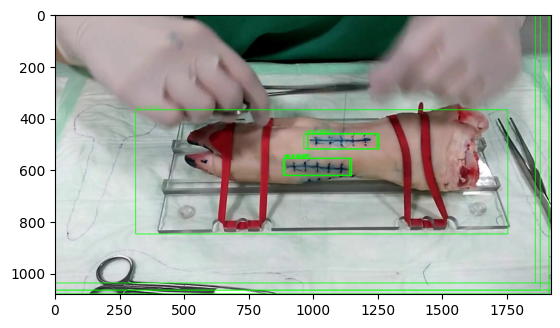

In [12]:
plt.imshow(img_rgb)